In [1]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


import matplotlib.patches as mpatches
from scipy.stats import fisher_exact

import IPython.display
IPython.display.display(IPython.display.HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('./../src/')
from manuscript import flow_sankey as sankey
from manuscript import clustering, datasets, inout, export


import itertools
import scipy.stats
import statsmodels.stats.multitest
import statannotations.Annotator

pd.options.display.max_columns = 200
mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["font.family"] = "Arial"

fonts = inout.get_resource_path('fonts')
for f in os.listdir(fonts):
    if f.endswith(".ttf"):
        mpl.font_manager.fontManager.addfont(f"{fonts}/{f}")
        
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"


def dump_table(df, name):
    export.full_frame(
        user, 
        f'{outfolder}/{name}', 
        df, 
        index=True,
        date=True
    )

def dump_figure(name):
    export.image(
        user,
        f'{outfolder}/{name}',
    )
    

In [2]:
user = 'general'     # defines top hierarchy of output folder
outfolder = '09_VAP_plots'    # name of notebook


In [3]:
def stacked_hue_barplot(df, x, y, hue, stacks, ax, palette=None):
    if palette is None:
        palette = mpl.cm.tab10
    bar_gap = 1
    bar_width = 2
    col_pad = 2
    n_bars = len(stacks)
    n_cols = df[x].nunique()
    col_width = n_bars * bar_width + (n_bars - 1) * bar_gap + 2 * col_pad
    col_values = pd.Series(df[x].unique()).sort_values().reset_index(drop=True)
    hue_values = pd.Series(df[hue].unique()).sort_values().reset_index(drop=True)
    bar_values = pd.Series(range(len(stacks))).sort_values().reset_index(drop=True)
    to_display = pd.DataFrame(dict(
        col=np.repeat(col_values, n_bars), 
        bar=np.tile(bar_values, n_cols),
        bar_num=np.tile(bar_values.index, n_cols)
    )).reset_index().rename({"index": "col_num"}, axis=1)
    to_display["bar_pos"] = to_display.apply(
        lambda x: x.col_num * col_width + x.bar_num * bar_width + (x.bar_num - 1) * bar_gap + col_pad, 
        axis=1
    )
    max_stack = max([len(group) for group in stacks])
    bottom = np.zeros(to_display.shape[0])
    for i in range(max_stack):
        curr_stack = {j: group[-i - 1] for j, group in enumerate(stacks) if i < len(group)}
        to_display["bar_value"] = to_display.bar.map(curr_stack)
        count = to_display.merge(
            df.loc[df[hue].isin(curr_stack.values()), :], 
            left_on=["col", "bar_value"], 
            right_on=[x, hue],
            how="left"
        )[y].fillna(0)
        ax.bar(
            to_display.bar_pos, 
            count, 
            color=[palette(hue_values.index[hue_values == i]) 
                   for i in to_display.bar_value.fillna(hue_values.values[0])],
            ec="#333333",
            width=bar_width,
            align="edge",
            bottom=bottom
        )
        bottom += count
    ax.set_xticks(col_values.index * col_width + col_width / 2 + -1 * bar_gap)
    ax.set_xticklabels(col_values, size=16)
    ax.set_ylim((0, bottom.max() + bottom.max() * 0.1))

    bar_handles = []
    for i, b in enumerate(hue_values):
        bar_handles.append(mpl.patches.Patch(color=palette(i), label=b, ec="#333333"))
    ax.legend(
        handles=bar_handles, 
        loc="upper right", 
        title="Discharge disposition", 
        frameon=False,
        fontsize=14,
        title_fontsize=12
    )
    return ax

# Take only adjudicated patient-days

In [4]:
data = pd.read_csv(
    inout.get_material_path("general/02_recode_transplants/02data-internal_220901_1009.csv.gz"), index_col=0)
data['day_bucket_stars']=pd.to_datetime(data['day_bucket_starts'])

#take episode data
episodes = data.loc[~data.Episode_category.isna(), :]

#first episode date 
first_ep = episodes.sort_values(by=['patient','day_bucket_starts']).drop_duplicates(subset=['patient'])
first_ep_day = first_ep[['patient','day_bucket_starts']]
first_ep_day = first_ep_day.rename(columns={'day_bucket_starts':'enrollment_bal_date'})

#merge back
data_enroll_bal = pd.merge(data, first_ep_day, how='left', on='patient')

#filter by enrollment bal 
data_enroll_bal['after_enrollment'] = np.where((data_enroll_bal['day_bucket_starts']>=data_enroll_bal['enrollment_bal_date']),1,0)
data_enroll_bal=data_enroll_bal[data_enroll_bal['after_enrollment']==1]

data = data_enroll_bal.copy()

In [5]:
data.shape

(9850, 88)

In [6]:
data.patient.nunique()

585

In [7]:
DISCH_PALETTE = [
    "tab:blue", #home
    "lightseagreen", #rehab
    "beige", #snf
    "gold",#ltach
    "orange",#hospice
    "crimson",#died 
]

DISCHARGE_STACKS = [
    ('Home', 'Rehab', 'SNF', 'LTACH'),
    ('Hospice', 'Died')
]

data.Discharge_disposition = data.Discharge_disposition.astype("category")
data.Discharge_disposition = data.Discharge_disposition.cat.reorder_categories([
        'Home', 
        'Rehab', 
        'SNF', 
        'LTACH',
        'Hospice', 
        'Died'
    ])

# Select non-viral VAPs

In [8]:
vap_idx = data.Episode_category.eq("VAP") & data.Episode_etiology.ne("Viral")
vap_idx.sum()

279

In [9]:
vap_days_idx = pd.DataFrame(False, index=data.index, columns=pd.MultiIndex.from_tuples([
    (False, "Cured"),
    (False, "Not cured/Indeterminate"),
    (True, "Cured"),
    (True, "Not cured/Indeterminate"),
]))
vap_cured = pd.Series(index=data.index, dtype=pd.StringDtype())

# What % of COVID vs non-COVID patients had non-viral VAP in this adjudicated group?

In [10]:
non_viral_vap = data[data.Episode_category.eq("VAP") & data.Episode_etiology.ne("Viral")]
unique = non_viral_vap.drop_duplicates(subset='patient')

In [11]:
had_vap = unique.groupby('COVID_status').agg({"patient": "count"}).reset_index().rename({"patient": "had_nonviral_vap"}, axis=1)
covid_split = data.drop_duplicates(subset='patient').groupby('COVID_status').agg({"patient": "count"}).reset_index().rename({"patient": "total_patients"}, axis=1)
plot_df = pd.merge(had_vap, covid_split, how='left', on='COVID_status')
plot_df['percent_had_vap']=plot_df['had_nonviral_vap']/plot_df['total_patients']
plot_df['did_not']=plot_df['total_patients']-plot_df['had_nonviral_vap']
plot_df['total']=1
plot_df

,COVID_status,had_nonviral_vap,total_patients,percent_had_vap,did_not,total
0,False,98,395,0.248101,297,1
1,True,109,190,0.573684,81,1


In [12]:
stats_results = []

for d1, d2 in itertools.combinations(plot_df.COVID_status.unique(), 2):
        had_nonviral_vap1 = plot_df['had_nonviral_vap'][plot_df.COVID_status==d1].dropna()
        had_nonviral_vap2 = plot_df['had_nonviral_vap'][plot_df.COVID_status==d2].dropna()
        did_not1 = plot_df['did_not'][plot_df.COVID_status==d1].dropna()
        did_not2 = plot_df['did_not'][plot_df.COVID_status==d2].dropna()

        odds, pval = fisher_exact([ [had_nonviral_vap1[0], had_nonviral_vap2[1]],
                                        [did_not1[0], did_not2[1]]])
        stats_results.append([d1, d2, pval])  

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2","pval"])
stats_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval, alpha=0.05)[1]
stat_results_sign = stats_results.loc[stats_results.pval < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))
stat_results_sign

,group1,group2,pval,pval_adj
0,False,True,3.032779e-14,3.032779e-14


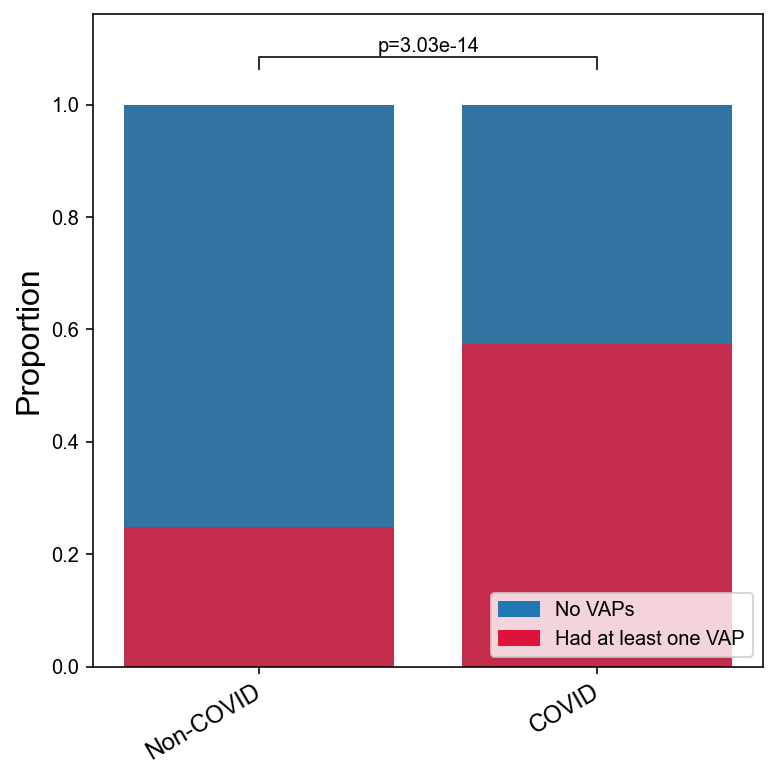

In [13]:
fig, ax = plt.subplots(figsize=(6, 6))
bar1 = sns.barplot(x="COVID_status",  y="total", data=plot_df, color='tab:blue')
bar2 = sns.barplot(x="COVID_status", y="percent_had_vap", data=plot_df, color='crimson')

top_bar = mpatches.Patch(color='tab:blue', label='No VAPs')
bottom_bar = mpatches.Patch(color='crimson', label='Had at least one VAP')
plt.legend(handles=[top_bar, bottom_bar], loc="lower right")
# ax.legend_.set_bbox_to_anchor((0.5, 1))

ax.set_ylabel("Proportion", size=16)

ax.set_xlabel("")
ax.set_xticklabels(["Non-COVID", "COVID"], size=16)

ax.tick_params(axis='x', labelsize=12)
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_rotation(30)
    t.set_horizontalalignment("right")
    t.set_transform(t.get_transform() + trans)
    
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=plot_df, 
    x="COVID_status",
    y="percent_had_vap", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"p={x:.2e}" for x in stat_results_sign.pval])
annotator.annotate();
dump_figure("had_nonviral_VAP.pdf")

# What % had more than one VAP?

In [14]:
#count number of nonv-viral VAPs
n_vaps = non_viral_vap.groupby(["patient", "COVID_status"]).apply(
    lambda x: x.Episode_category.eq("VAP").sum()
).reset_index().rename({0: "n_VAPs"}, axis="columns")
n_vaps.groupby('COVID_status').agg({'patient':'count'}).reset_index().rename({'patient':'multiple_VAPs'})

,COVID_status,patient
0,False,98
1,True,109


In [15]:
#multiple VAPs? 
count_vaps = n_vaps[n_vaps.n_VAPs>1].COVID_status.value_counts().reset_index().rename({'COVID_status':'multiple_VAPs'})
n_vaps[n_vaps.n_VAPs>1].COVID_status.value_counts().reset_index()

,index,COVID_status
0,True,37
1,False,13


In [16]:
plot_df2 = pd.merge(count_vaps, covid_split, how='left', left_on='index', right_on='COVID_status')
plot_df2['percent_multiple_VAPs']=plot_df2['COVID_status_x']/plot_df2['total_patients']
plot_df2['total']=1
plot_df2['did_not']=plot_df2['total_patients']-plot_df2['COVID_status_x']
plot_df2

,index,COVID_status_x,COVID_status_y,total_patients,percent_multiple_VAPs,total,did_not
0,True,37,True,190,0.194737,1,153
1,False,13,False,395,0.032911,1,382


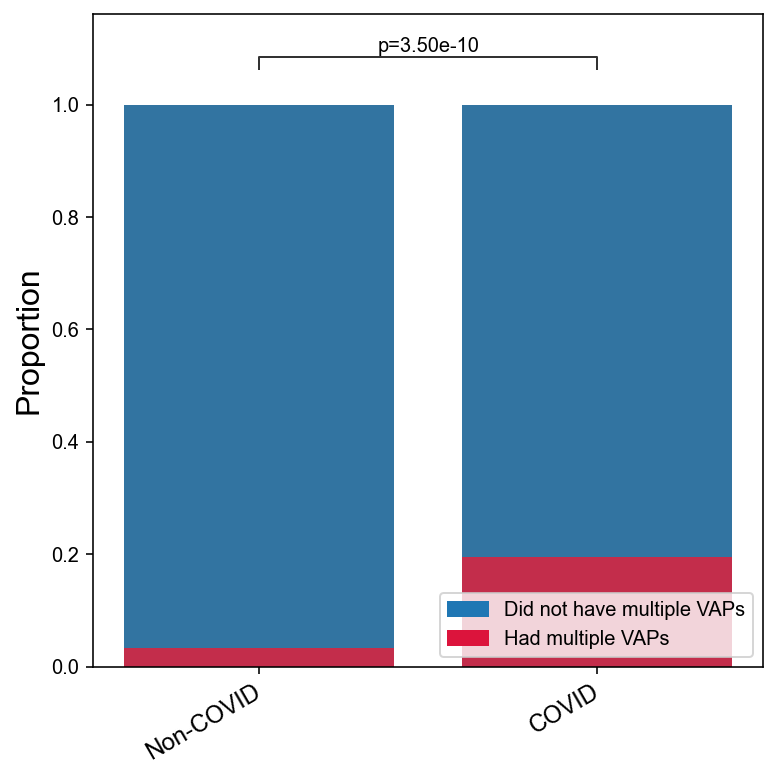

In [17]:
plot_df=plot_df2.copy()
stats_results = []

for d1, d2 in itertools.combinations(plot_df.COVID_status_y.unique(), 2):
        had_multiple_vap1 = plot_df['COVID_status_x'][plot_df.COVID_status_y==d1].dropna()
        had_multiple_vap2 = plot_df['COVID_status_x'][plot_df.COVID_status_y==d2].dropna()
        did_not1 = plot_df['did_not'][plot_df.COVID_status_y==d1].dropna()
        did_not2 = plot_df['did_not'][plot_df.COVID_status_y==d2].dropna()

        stat, pval= fisher_exact([ [had_multiple_vap1[0], had_multiple_vap2[1]],
                                        [did_not1[0], did_not2[1]]])
        stats_results.append([d1, d2, pval])  

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2","pval"])
stats_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval, alpha=0.05)[1]
stat_results_sign = stats_results.loc[stats_results.pval_adj < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))
stats_results

fig, ax = plt.subplots(figsize=(6, 6))
bar1 = sns.barplot(x="COVID_status_y",  y="total", data=plot_df2, color='tab:blue')
bar2 = sns.barplot(x="COVID_status_y", y="percent_multiple_VAPs", data=plot_df2, color='crimson')

top_bar = mpatches.Patch(color='tab:blue', label='Did not have multiple VAPs')
bottom_bar = mpatches.Patch(color='crimson', label='Had multiple VAPs')
plt.legend(handles=[top_bar, bottom_bar], loc="lower right")
# ax.legend_.set_bbox_to_anchor((1, 0.8))

ax.set_ylabel("Proportion", size=16)

ax.set_xlabel("")
ax.set_xticklabels(["Non-COVID", "COVID"], size=16)

ax.tick_params(axis='x', labelsize=12)
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_rotation(30)
    t.set_horizontalalignment("right")
    t.set_transform(t.get_transform() + trans)
    
    
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=plot_df2, 
    x="COVID_status_y",
    y="percent_multiple_VAPs", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"p={x:.2e}" for x in stat_results_sign.pval])
annotator.annotate();

dump_figure("had_multiple_nonviral_VAP.pdf")

# Single-episode patients with VAP split by cured

In [19]:
#define cohort
df = data.loc[data.Episode_category.isin(["CAP", "HAP", "VAP"]), :]
one_episode_pts = df.groupby("patient").ICU_day.count().eq(1).replace({False: np.nan}).dropna().index
plot_df = df.loc[vap_idx & df.patient.isin(one_episode_pts)]
plot_df = plot_df.groupby(
    ["Discharge_disposition", "Episode_is_cured"]
).ICU_day.count().reset_index().rename({"ICU_day": "cnt"}, axis="columns")
plot_df["Binary_outcome"] = "Positive"
plot_df.loc[plot_df.Discharge_disposition.isin(["Hospice", "Died"]), "Binary_outcome"] = "Negative"
simple_df = plot_df.groupby(["Episode_is_cured", "Binary_outcome"]).cnt.sum().reset_index()


# Compute stats
helper = plot_df.copy()
helper.loc[:, 'passed'] = helper['Discharge_disposition'].isin(['Hospice', 'Died'])
obs = helper.groupby(['Episode_is_cured', 'passed'])['cnt'].sum()

stats_results = []

states = ['Cured', 'Indeterminate', 'Not cured']
# Changed `product` to `combinations`
for cat_a, cat_b in itertools.combinations(states, r=2):
        pval = fisher_exact(
            (
                (
                    obs.loc[(cat_a, False)], obs.loc[(cat_a, True)]
                ),
                (
                    obs.loc[(cat_b, False)], obs.loc[(cat_b, True)]
                )
            )
        )[1]
        stats_results.append([cat_a, cat_b, pval])

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2", "pval"])
pairs = []
# for _, r in stats_results.iterrows():
#         pairs.append((r.group1, r.group2))

stats_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval, alpha=0.05)[1]

stat_results_sign = stats_results.loc[stats_results.pval_adj < 0.05, :]
# pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))
stat_results_sign

,group1,group2,pval,pval_adj
0,Cured,Indeterminate,6.747020e-05,1.012053e-04
1,Cured,Not cured,2.745153e-08,8.235459e-08


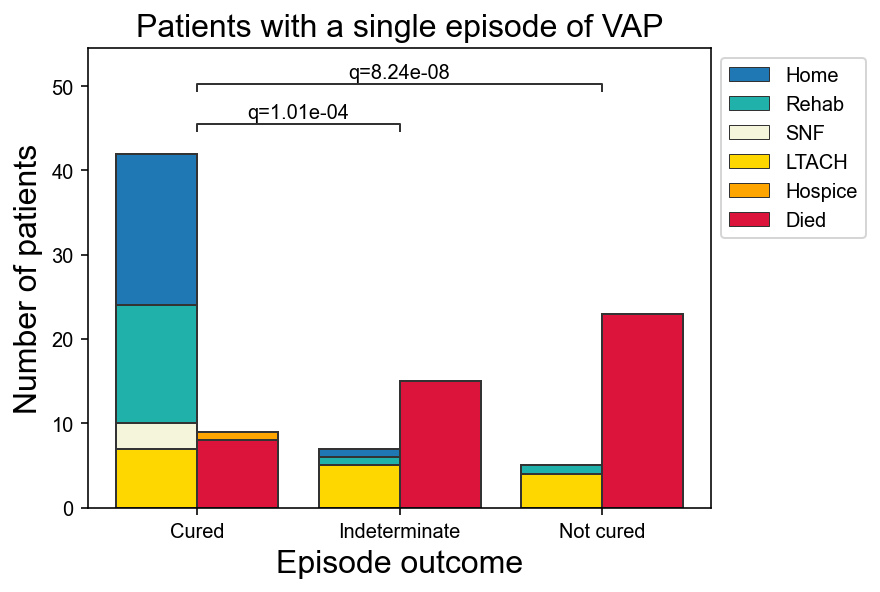

In [20]:
#define cohort
df = data.loc[data.Episode_category.isin(["CAP", "HAP", "VAP"]), :]
one_episode_pts = df.groupby("patient").ICU_day.count().eq(1).replace({False: np.nan}).dropna().index
plot_df = df.loc[vap_idx & df.patient.isin(one_episode_pts)]
plot_df = plot_df.groupby(
    ["Discharge_disposition", "Episode_is_cured"]
).ICU_day.count().reset_index().rename({"ICU_day": "cnt"}, axis="columns")
plot_df["Binary_outcome"] = "Positive"
plot_df.loc[plot_df.Discharge_disposition.isin(["Hospice", "Died"]), "Binary_outcome"] = "Negative"
simple_df = plot_df.groupby(["Episode_is_cured", "Binary_outcome"]).cnt.sum().reset_index()

#plot
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

# Plot Binary outcomes fully transparent
sns.barplot(
    data=simple_df, 
    x="Episode_is_cured", 
    y="cnt",
    hue="Binary_outcome", 
    hue_order=["Positive", "Negative"],
    ax=ax, 
    alpha=0
)

ax.set_ylabel("Number of patients", size=16)
ax.set_xlabel("Episode outcome", size=16)
ax.set_title("Patients with a single episode of VAP", size=16)

# Compute stats
helper = plot_df.copy()
helper.loc[:, 'passed'] = helper['Discharge_disposition'].isin(['Hospice', 'Died'])
obs = helper.groupby(['Episode_is_cured', 'passed'])['cnt'].sum()

stats_results = []

states = ['Cured', 'Indeterminate', 'Not cured']
# Changed `product` to `combinations`
for cat_a, cat_b in itertools.combinations(states, r=2):
        pval = fisher_exact(
            (
                (
                    obs.loc[(cat_a, False)], obs.loc[(cat_a, True)]
                ),
                (
                    obs.loc[(cat_b, False)], obs.loc[(cat_b, True)]
                )
            )
        )[1]
        stats_results.append([cat_a, cat_b, pval])

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2", "pval"])
pairs = []
# for _, r in stats_results.iterrows():
#         pairs.append((r.group1, r.group2))

stats_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval, alpha=0.05)[1]

stat_results_sign = stats_results.loc[stats_results.pval_adj < 0.05, :]
# pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))
        
        
# Annotate with stats the transparent plot
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=simple_df, 
    x="Episode_is_cured",
    y="cnt", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}" for x in stat_results_sign.pval_adj])
annotator.annotate();

# Plot all Discharge dispositions
annotator = statannotations.Annotator.Annotator(
    ax, 
    [(("Cured", "Positive"), ("Cured", "Negative"))], 
    data=simple_df, 
    x="Episode_is_cured",
    y="cnt", 
    hue="Binary_outcome",
    hue_order=["Positive", "Negative"],
    verbose=False,
)
max_stack = max([len(group) for group in DISCHARGE_STACKS])
bottom = np.zeros(len(annotator._plotter.group_names))
for i in range(max_stack):
    curr_stack = [group[-i - 1] for j, group in enumerate(DISCHARGE_STACKS) if i < len(group)]
    heights = plot_df.loc[plot_df.Discharge_disposition.isin(curr_stack)].set_index(
        ["Episode_is_cured", "Binary_outcome"]
    ).reindex(annotator._plotter.group_names).cnt.fillna(0)
    ax.bar(
        annotator._plotter.groups_positions._groups_positions_list, 
        heights, 
        color=[DISCH_PALETTE[data.Discharge_disposition.cat.categories.get_loc(x)] for x in curr_stack],
        ec="#333333",
        width=annotator._plotter.plotter.width / len(annotator._plotter.plotter.hue_names),
        align="center",
        bottom=bottom,
    )
    bottom += heights


ax.legend(
    [
        plt.Rectangle(
            [0, 0], 0, 0,
            linewidth=0.5,
            edgecolor="#333",
            facecolor=color,
            label=label
        ) for color, label in zip(DISCH_PALETTE, data.Discharge_disposition.cat.categories)
    ],
    data.Discharge_disposition.cat.categories,loc=2, bbox_to_anchor=(1, 1),
)
    
dump_figure("single_episode_VAP_outcomes.pdf")

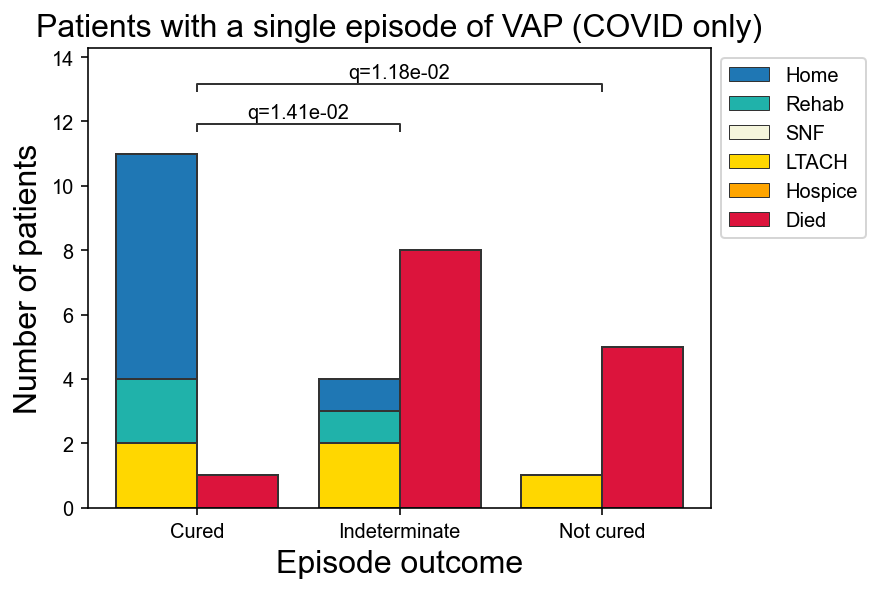

In [21]:
#define cohort
plot_df = df.loc[vap_idx & df.patient.isin(one_episode_pts)]
plot_df = plot_df.loc[plot_df.COVID_status].groupby(
    ["Discharge_disposition", "Episode_is_cured"]
).ICU_day.count().reset_index().rename({"ICU_day": "cnt"}, axis="columns")
plot_df["Binary_outcome"] = "Positive"
plot_df.loc[plot_df.Discharge_disposition.isin(["Hospice", "Died"]), "Binary_outcome"] = "Negative"
simple_df = plot_df.groupby(["Episode_is_cured", "Binary_outcome"]).cnt.sum().reset_index()

#plot
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

# Plot Binary outcomes fully transparent
sns.barplot(
    data=simple_df, 
    x="Episode_is_cured", 
    y="cnt",
    hue="Binary_outcome", 
    hue_order=["Positive", "Negative"],
    ax=ax, 
    alpha=0
)

ax.set_ylabel("Number of patients", size=16)
ax.set_xlabel("Episode outcome", size=16)
ax.set_title("Patients with a single episode of VAP (COVID only)", size=16)

# Compute stats
helper = plot_df.copy()
helper.loc[:, 'passed'] = helper['Discharge_disposition'].isin(['Hospice', 'Died'])
obs = helper.groupby(['Episode_is_cured', 'passed'])['cnt'].sum()

stats_results = []

states = ['Cured', 'Indeterminate', 'Not cured']
# Changed `product` to `combinations`
for cat_a, cat_b in itertools.combinations(states, r=2):
        pval = fisher_exact(
            (
                (
                    obs.loc[(cat_a, False)], obs.loc[(cat_a, True)]
                ),
                (
                    obs.loc[(cat_b, False)], obs.loc[(cat_b, True)]
                )
            )
        )[1]
        stats_results.append([cat_a, cat_b, pval])

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2", "pval"])
# pairs = []
# for _, r in stats_results.iterrows():
#         pairs.append((r.group1, r.group2))

stats_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval, alpha=0.05)[1]
stat_results_sign = stats_results.loc[stats_results.pval_adj < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))



# Annotate with stats the transparent plot
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=simple_df, 
    x="Episode_is_cured",
    y="cnt", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}" for x in stat_results_sign.pval_adj])
annotator.annotate();

# Plot all Discharge dispositions
annotator = statannotations.Annotator.Annotator(
    ax, 
    [(("Cured", "Positive"), ("Cured", "Negative"))], 
    data=simple_df, 
    x="Episode_is_cured",
    y="cnt", 
    hue="Binary_outcome",
    hue_order=["Positive", "Negative"],
    verbose=False,
)
max_stack = max([len(group) for group in DISCHARGE_STACKS])
bottom = np.zeros(len(annotator._plotter.group_names))
for i in range(max_stack):
    curr_stack = [group[-i - 1] for j, group in enumerate(DISCHARGE_STACKS) if i < len(group)]
    heights = plot_df.loc[plot_df.Discharge_disposition.isin(curr_stack)].set_index(
        ["Episode_is_cured", "Binary_outcome"]
    ).reindex(annotator._plotter.group_names).cnt.fillna(0)
    ax.bar(
        annotator._plotter.groups_positions._groups_positions_list, 
        heights, 
        color=[DISCH_PALETTE[data.Discharge_disposition.cat.categories.get_loc(x)] for x in curr_stack],
        ec="#333333",
        width=annotator._plotter.plotter.width / len(annotator._plotter.plotter.hue_names),
        align="center",
        bottom=bottom,
    )
    bottom += heights


# ax.legend_.set_bbox_to_anchor((1, 1))
# ax.legend_._loc = 2
ax.legend(
    [
        plt.Rectangle(
            [0, 0], 0, 0,
            linewidth=0.5,
            edgecolor="#333",
            facecolor=color,
            label=label
        ) for color, label in zip(DISCH_PALETTE, data.Discharge_disposition.cat.categories)
    ],
    data.Discharge_disposition.cat.categories,loc=2, bbox_to_anchor=(1, 1),
)
    
dump_figure("single_episode_VAP_outcomes_COVID.pdf")

In [22]:

# Compute stats
helper = plot_df.copy()
helper.loc[:, 'passed'] = helper['Discharge_disposition'].isin(['Hospice', 'Died'])
obs = helper.groupby(['Episode_is_cured', 'passed'])['cnt'].sum()

stats_results = []

states = ['Cured', 'Indeterminate', 'Not cured']
# Changed `product` to `combinations`
for cat_a, cat_b in itertools.combinations(states, r=2):
        pval = fisher_exact(
            (
                (
                    obs.loc[(cat_a, False)], obs.loc[(cat_a, True)]
                ),
                (
                    obs.loc[(cat_b, False)], obs.loc[(cat_b, True)]
                )
            )
        )[1]
        stats_results.append([cat_a, cat_b, pval])

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2", "pval"])
# pairs = []
# for _, r in stats_results.iterrows():
#         pairs.append((r.group1, r.group2))

stats_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval, alpha=0.05)[1]
stat_results_sign = stats_results.loc[stats_results.pval_adj < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))
stat_results_sign

,group1,group2,pval,pval_adj
0,Cured,Indeterminate,0.009423,0.014134
1,Cured,Not cured,0.003932,0.011797


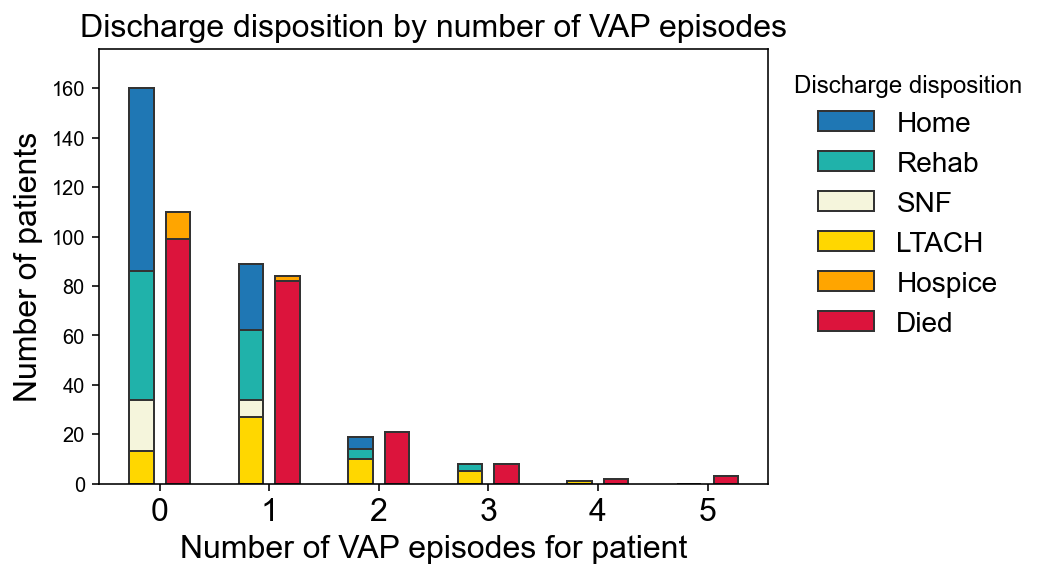

In [23]:
plot_df = df.groupby(["patient", "Discharge_disposition"]).apply(
    lambda x: x.Episode_category.eq("VAP").sum()
).reset_index().rename({0: "n_VAPs"}, axis="columns")
plot_df = plot_df.groupby(["n_VAPs", "Discharge_disposition"]).agg(
    {"patient": "count"}
).reset_index().rename({"patient": "cnt"}, axis=1)

fig, ax = plt.subplots(figsize=(6, 4))
stacked_hue_barplot(
    df=plot_df, 
    x="n_VAPs", 
    y="cnt",
    hue="Discharge_disposition", 
    stacks=DISCHARGE_STACKS,
    ax=ax, 
    palette=mpl.colors.ListedColormap(DISCH_PALETTE),
)
ax.legend_._loc = 2
ax.legend_.set_bbox_to_anchor((1, 1))
ax.set_xlabel("Number of VAP episodes for patient", size=16)
ax.set_ylabel("Number of patients", size=16)
ax.set_title(
    "Discharge disposition by number of VAP episodes", 
    size=16
);
dump_figure('dispo_multiple_VAP_episodes.pdf')

In [24]:
helper = plot_df.copy()
helper.loc[:, 'passed'] = helper['Discharge_disposition'].isin(['Hospice', 'Died'])

obs = helper.groupby(['n_VAPs', 'passed'])['cnt'].sum()

for ep in [0, 1, 2, 3,4]:
    next_episodes = ep+1

    pval = fisher_exact(
        (
            (
                obs.loc[(ep, False)], obs.loc[(ep, True)]
            ),
            (
                obs.loc[(next_episodes, False)], obs.loc[(next_episodes, True)]
            )
        )
    )[1]

    print(f'{ep} to {next_episodes} has pvalue of {pval:.2f} to differ.')

0 to 1 has pvalue of 0.12 to differ.
1 to 2 has pvalue of 0.73 to differ.
2 to 3 has pvalue of 1.00 to differ.
3 to 4 has pvalue of 1.00 to differ.
4 to 5 has pvalue of 1.00 to differ.


In [25]:
mortality_by_vaps = df.groupby(["patient","Binary_outcome"]).apply(
    lambda x: x.Episode_category.eq("VAP").sum()
).reset_index().rename({0: "n_VAPs"}, axis="columns")
mortality_by_vaps = mortality_by_vaps.groupby(["n_VAPs", "Binary_outcome"]).agg(
    {"patient": "count"}
).reset_index().rename({"patient": "number"}, axis=1)
mortality_by_vaps

,n_VAPs,Binary_outcome,number
0,0,0,160
1,0,1,110
2,1,0,89
3,1,1,84
4,2,0,19
5,2,1,21
6,3,0,8
7,3,1,8
8,4,0,1
9,4,1,2


In [26]:
sum_vaps = mortality_by_vaps.groupby('n_VAPs').sum('number').reset_index()
sum_vaps = sum_vaps[['n_VAPs','number']].rename(columns={'number':'total'})
mortality_by_vaps = pd.merge(mortality_by_vaps, sum_vaps, how='left')
mortality_by_vaps['percent'] = mortality_by_vaps['number']/mortality_by_vaps['total']
mortality_by_vaps

,n_VAPs,Binary_outcome,number,total,percent
0,0,0,160,270,0.592593
1,0,1,110,270,0.407407
2,1,0,89,173,0.514451
3,1,1,84,173,0.485549
4,2,0,19,40,0.475000
5,2,1,21,40,0.525000
6,3,0,8,16,0.500000
7,3,1,8,16,0.500000
8,4,0,1,3,0.333333
9,4,1,2,3,0.666667


# VAPs and mortality

In [27]:
non_viral_vap = data[data.Episode_category.eq("VAP") & data.Episode_etiology.ne("Viral")]
unique = non_viral_vap.drop_duplicates(subset='patient')
unique_list = unique['Patient_id']
data['had_vap'] = np.where(data['Patient_id'].isin(unique_list),1,0)
data_unique = data.drop_duplicates(subset='patient')

In [28]:
plot_df = data_unique.copy()
plot_df = data_unique.groupby(['Binary_outcome','had_vap']).agg({'patient':'count'}).reset_index().rename(columns={'patient':'count'})
number_vaps = plot_df.groupby('had_vap').agg({'count':'sum'}).reset_index().rename(columns={'count':'total'})
plot_df=pd.merge(plot_df,number_vaps)
plot_df['whole']=1
plot_df['percent']=plot_df['count']/plot_df['total']
plot_df['Binary_outcome']=plot_df['Binary_outcome'].replace({0:'Died',1:'Lived'})
plot_df['had_vap']=plot_df['had_vap'].replace({0:'No VAP',1:'Had at least one VAP'})
plot_df2=plot_df[plot_df.Binary_outcome==('Lived')]
plot_df2

,Binary_outcome,had_vap,count,total,whole,percent
1,Lived,No VAP,161,378,1,0.425926
3,Lived,Had at least one VAP,101,207,1,0.487923


In [29]:
#Fisher exact p=0.1644

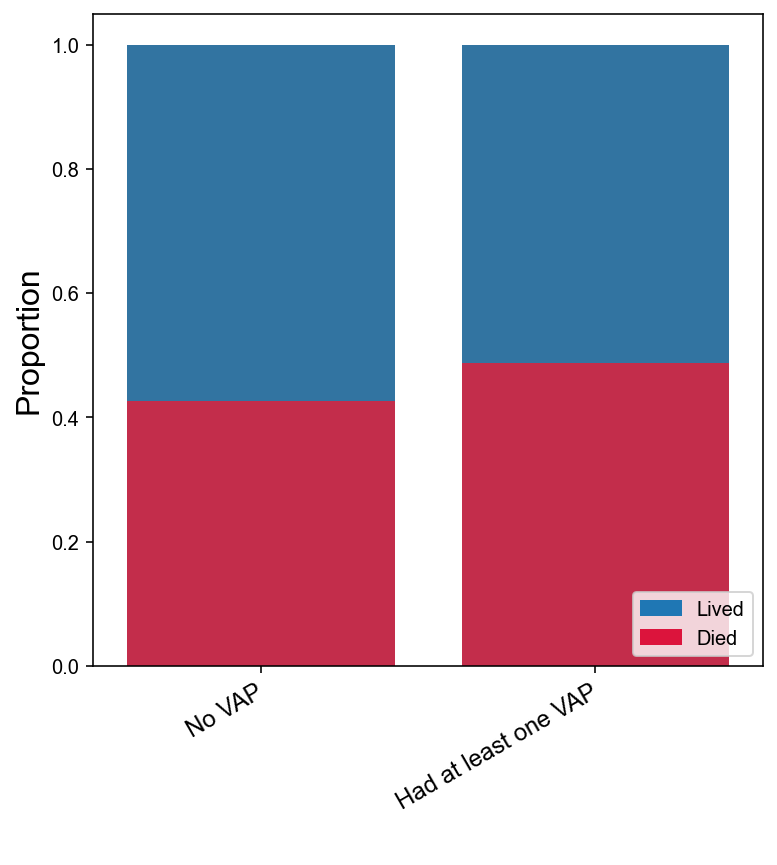

In [30]:
fig, ax = plt.subplots(figsize=(6, 6))
bar1 = sns.barplot(x="had_vap",  y="whole", data=plot_df2, color='tab:blue')
bar2 = sns.barplot(x="had_vap", y="percent", data=plot_df2, color='crimson')

top_bar = mpatches.Patch(color='tab:blue', label='Lived')
bottom_bar = mpatches.Patch(color='crimson', label='Died')
plt.legend(handles=[top_bar, bottom_bar], loc="lower right")
# ax.legend_.set_bbox_to_anchor((1, 0.8))

ax.set_ylabel("Proportion", size=16)
ax.set_xlabel(" ", size=16)

ax.tick_params(axis='x', labelsize=12)
trans = mpl.transforms.Affine2D().translate(6, 0)
for t in ax.get_xticklabels():
    t.set_rotation(30)
    t.set_horizontalalignment("right")
    t.set_transform(t.get_transform() + trans)
    
# annotator = statannotations.Annotator.Annotator(
#     ax, 
#     pairs, 
#     data=plot_df, 
#     x="COVID_status",
#     y="percent_had_vap", 
#     verbose=False
# )
# annotator._verbose = False
# annotator.configure(line_width=1)
# annotator.set_custom_annotations([f"p={x:.2e}" for x in stat_results_sign.pval])
# annotator.annotate();
dump_figure("VAP_status_lived.pdf")

In [31]:
# Broken down by Category

In [32]:
categories_vaps=data_unique.groupby(['Patient_category','Binary_outcome','had_vap']).agg({'patient':'count'}).reset_index()
categories_vaps

,Patient_category,Binary_outcome,had_vap,patient
0,COVID-19,0,0,50
1,COVID-19,0,1,53
2,COVID-19,1,0,31
3,COVID-19,1,1,56
4,Non-Pneumonia Control,0,0,46
5,Non-Pneumonia Control,0,1,4
6,Non-Pneumonia Control,1,0,35
7,Non-Pneumonia Control,1,1,8
8,Other Pneumonia,0,0,100
9,Other Pneumonia,0,1,43


In [33]:
#differences not stat sig by Fisher's exact 

fisher_exact( [
            ( categories_vaps.loc[((categories_vaps.Patient_category==('Non-Pneumonia Control')) 
                     & (categories_vaps.Binary_outcome==0)
                     & (categories_vaps.had_vap==0)), 'patient'].values[0], 
             categories_vaps.loc[((categories_vaps.Patient_category==('Non-Pneumonia Control')) 
                     & (categories_vaps.Binary_outcome==0)
                     & (categories_vaps.had_vap==1)), 'patient'].values[0]),
           ( categories_vaps.loc[((categories_vaps.Patient_category==('Non-Pneumonia Control')) 
                     & (categories_vaps.Binary_outcome==1)
                     & (categories_vaps.had_vap==0)), 'patient'].values[0], 
             categories_vaps.loc[((categories_vaps.Patient_category==('Non-Pneumonia Control')) 
                     & (categories_vaps.Binary_outcome==1)
                     & (categories_vaps.had_vap==1)), 'patient'].values[0] 
            )
            ]) 


(2.6285714285714286, 0.21369982700812645)

In [34]:
#differences not stat sig by Fisher's exact 

fisher_exact( [
            ( categories_vaps.loc[((categories_vaps.Patient_category==('Other Viral Pneumonia')) 
                     & (categories_vaps.Binary_outcome==0)
                     & (categories_vaps.had_vap==0)), 'patient'].values[0], 
             categories_vaps.loc[((categories_vaps.Patient_category==('Other Viral Pneumonia')) 
                     & (categories_vaps.Binary_outcome==0)
                     & (categories_vaps.had_vap==1)), 'patient'].values[0]),
           ( categories_vaps.loc[((categories_vaps.Patient_category==('Other Viral Pneumonia')) 
                     & (categories_vaps.Binary_outcome==1)
                     & (categories_vaps.had_vap==0)), 'patient'].values[0], 
             categories_vaps.loc[((categories_vaps.Patient_category==('Other Viral Pneumonia')) 
                     & (categories_vaps.Binary_outcome==1)
                     & (categories_vaps.had_vap==1)), 'patient'].values[0] 
            )
            ]) 


(0.525, 0.4789708065314202)

In [35]:
#differences not stat sig by Fisher's exact 

fisher_exact( [
            ( categories_vaps.loc[((categories_vaps.Patient_category==('Other Pneumonia')) 
                     & (categories_vaps.Binary_outcome==0)
                     & (categories_vaps.had_vap==0)), 'patient'].values[0], 
             categories_vaps.loc[((categories_vaps.Patient_category==('Other Pneumonia')) 
                     & (categories_vaps.Binary_outcome==0)
                     & (categories_vaps.had_vap==1)), 'patient'].values[0]),
           ( categories_vaps.loc[((categories_vaps.Patient_category==('Other Pneumonia')) 
                     & (categories_vaps.Binary_outcome==1)
                     & (categories_vaps.had_vap==0)), 'patient'].values[0], 
             categories_vaps.loc[((categories_vaps.Patient_category==('Other Pneumonia')) 
                     & (categories_vaps.Binary_outcome==1)
                     & (categories_vaps.had_vap==1)), 'patient'].values[0] 
            )
            ]) 


(1.054263565891473, 0.8906144956492854)

In [36]:
#differences not stat sig by Fisher's exact 

fisher_exact( [
            ( categories_vaps.loc[((categories_vaps.Patient_category==('COVID-19')) 
                     & (categories_vaps.Binary_outcome==0)
                     & (categories_vaps.had_vap==0)), 'patient'].values[0], 
             categories_vaps.loc[((categories_vaps.Patient_category==('COVID-19')) 
                     & (categories_vaps.Binary_outcome==0)
                     & (categories_vaps.had_vap==1)), 'patient'].values[0]),
           ( categories_vaps.loc[((categories_vaps.Patient_category==('COVID-19')) 
                     & (categories_vaps.Binary_outcome==1)
                     & (categories_vaps.had_vap==0)), 'patient'].values[0], 
             categories_vaps.loc[((categories_vaps.Patient_category==('COVID-19')) 
                     & (categories_vaps.Binary_outcome==1)
                     & (categories_vaps.had_vap==1)), 'patient'].values[0] 
            )
            ]) 


(1.704199634814364, 0.0791521309466955)

In [37]:
plot_df = data_unique.copy()
plot_df = data_unique[data_unique.COVID_status].groupby(['Binary_outcome','had_vap']).agg({'patient':'count'}).reset_index().rename(columns={'patient':'count'})
number_vaps = plot_df.groupby('had_vap').agg({'count':'sum'}).reset_index().rename(columns={'count':'total'})
plot_df=pd.merge(plot_df,number_vaps)
plot_df['whole']=1
plot_df['percent']=plot_df['count']/plot_df['total']
plot_df['Binary_outcome']=plot_df['Binary_outcome'].replace({0:'Died',1:'Lived'})
plot_df['had_vap']=plot_df['had_vap'].replace({0:'No VAP',1:'Had at least one VAP'})
plot_df2=plot_df[plot_df.Binary_outcome==('Lived')]
plot_df2

,Binary_outcome,had_vap,count,total,whole,percent
1,Lived,No VAP,31,81,1,0.382716
3,Lived,Had at least one VAP,56,109,1,0.513761


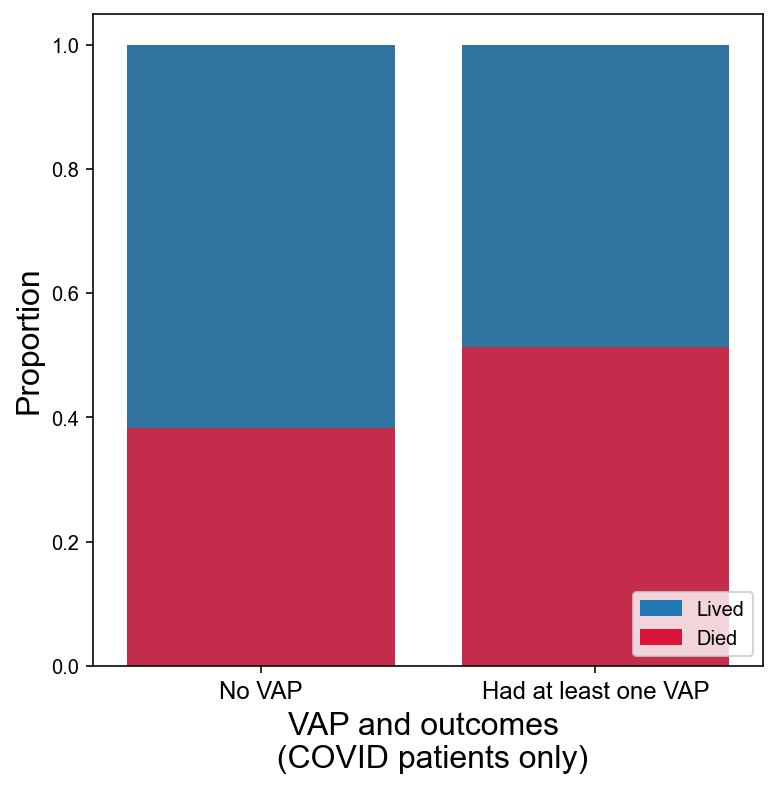

In [38]:
fig, ax = plt.subplots(figsize=(6, 6))
bar1 = sns.barplot(x="had_vap",  y="whole", data=plot_df2, color='tab:blue')
bar2 = sns.barplot(x="had_vap", y="percent", data=plot_df2, color='crimson')

top_bar = mpatches.Patch(color='tab:blue', label='Lived')
bottom_bar = mpatches.Patch(color='crimson', label='Died')
plt.legend(handles=[top_bar, bottom_bar], loc="lower right")
# ax.legend_.set_bbox_to_anchor((1, 0.8))

ax.set_ylabel("Proportion", size=16)
ax.set_xlabel("VAP and outcomes \n (COVID patients only)", size=16)

ax.tick_params(axis='x', labelsize=12)
# trans = mpl.transforms.Affine2D().translate(6, 0)
# for t in ax.get_xticklabels():
#     t.set_rotation(30)
#     t.set_horizontalalignment("right")
#     t.set_transform(t.get_transform() + trans)
    
# annotator = statannotations.Annotator.Annotator(
#     ax, 
#     pairs, 
#     data=plot_df, 
#     x="COVID_status",
#     y="percent_had_vap", 
#     verbose=False
# )
# annotator._verbose = False
# annotator.configure(line_width=1)
# annotator.set_custom_annotations([f"p={x:.2e}" for x in stat_results_sign.pval])
# annotator.annotate();
dump_figure("VAP_status_lived_COVID.pdf")

In [39]:
categories_vaps['Binary_outcome'] = categories_vaps['Binary_outcome'].replace({0:'Died',1:'Lived'})

In [40]:
categories_vaps.dtypes

Patient_category    object
Binary_outcome      object
had_vap              int64
patient              int64
dtype: object

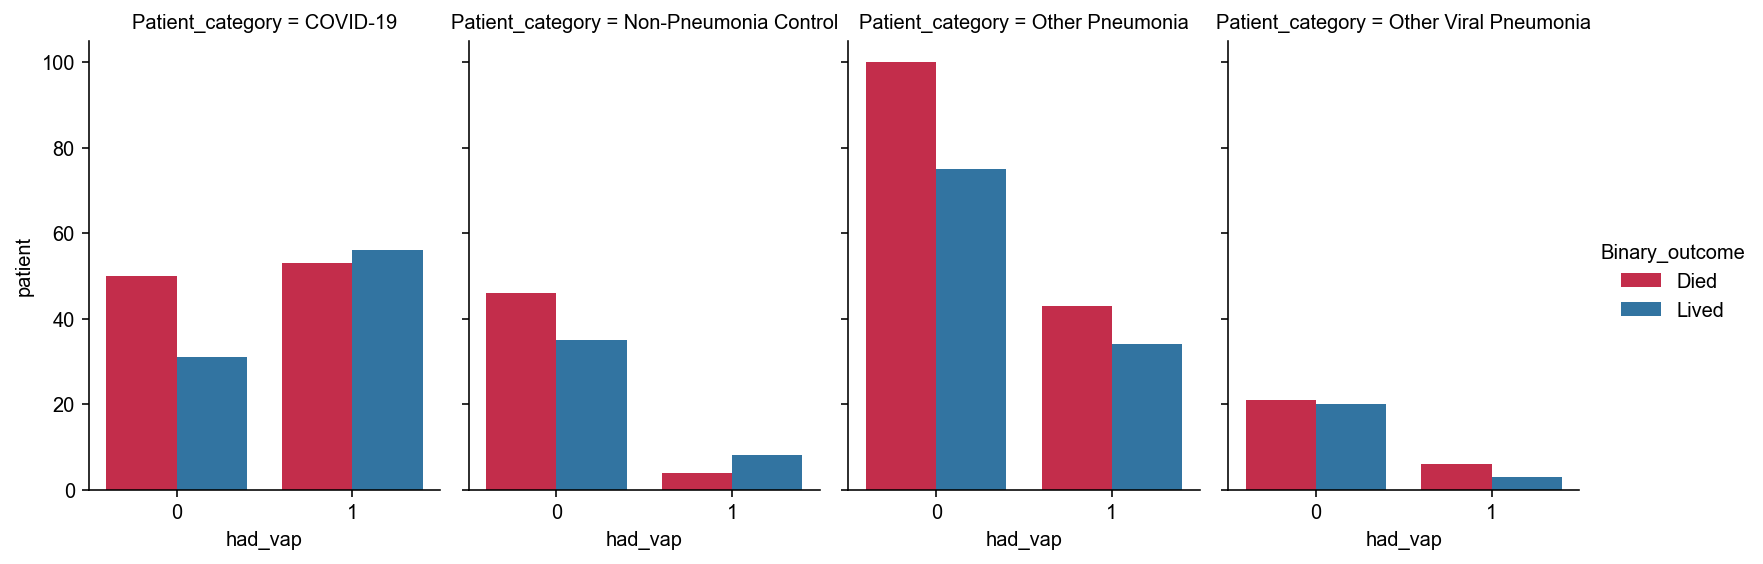

In [41]:
sns.color_palette("Paired")
# sns.set(font_scale=1.5)
# fig, ax = plt.subplots(figsize=(6, 6))

sns.catplot(
    data=categories_vaps,
    x='had_vap',
    y='patient',
    hue='Binary_outcome',
    palette=['crimson','tab:blue'],
    col='Patient_category',
    kind='bar',
    height=4,
    aspect=0.7,
    ci=None)

ax.set_xlabel("")
ax.set_ylabel("Patients", size=16)
# ax.set_xticklabels(["no VAP", "had VAP"], size=16)

dump_figure('category_vap_outcome.pdf')

# Analyse only VAPs that didn't end in patient death

In [74]:
#define cohort

vap_df = data[data.Episode_category.eq("VAP") & data.Episode_etiology.ne("Viral")].groupby("patient").tail(1)
vap_df.Death_date = pd.to_datetime(vap_df.Death_date)
vap_df.day_bucket_starts = pd.to_datetime(vap_df.day_bucket_starts)

vap_df = vap_df.loc[~((vap_df.Death_date - vap_df.day_bucket_starts).dt.days < 14), :]
long_vap_df = vap_df.copy()
plot_df = long_vap_df.groupby(
    ["Discharge_disposition", "Episode_is_cured"]
).agg({"patient": "count"}).reset_index().rename({"patient": "cnt"}, axis=1)
plot_df["Binary_outcome"] = "Positive"
plot_df.loc[plot_df.Discharge_disposition.isin(["Hospice", "Died"]), "Binary_outcome"] = "Negative"
simple_df = plot_df.groupby(["Episode_is_cured", "Binary_outcome"]).cnt.sum().reset_index()
simple_df


,Episode_is_cured,Binary_outcome,cnt
0,Cured,Negative,14
1,Cured,Positive,76
2,Indeterminate,Negative,20
3,Indeterminate,Positive,14
4,Not cured,Negative,13
5,Not cured,Positive,16


In [75]:

# Compute stats
helper = plot_df.copy()
helper.loc[:, 'passed'] = helper['Discharge_disposition'].isin(['Hospice', 'Died'])
obs = helper.groupby(['Episode_is_cured', 'passed'])['cnt'].sum()

stats_results = []

states = ['Cured', 'Indeterminate', 'Not cured']
# Changed `product` to `combinations`
for cat_a, cat_b in itertools.combinations(states, r=2):
        pval = fisher_exact(
            (
                (
                    obs.loc[(cat_a, False)], obs.loc[(cat_a, True)]
                ),
                (
                    obs.loc[(cat_b, False)], obs.loc[(cat_b, True)]
                )
            )
        )[1]
        stats_results.append([cat_a, cat_b, pval])

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2", "pval"])
pairs = []
# for _, r in stats_results.iterrows():
#         pairs.append((r.group1, r.group2))

stats_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval, alpha=0.05)[1]

stat_results_sign = stats_results.loc[stats_results.pval_adj < 0.05, :]
# pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))
stats_results        

,group1,group2,pval,pval_adj
0,Cured,Indeterminate,0.000006,0.000019
1,Cured,Not cured,0.002026,0.003040
2,Indeterminate,Not cured,0.317330,0.317330


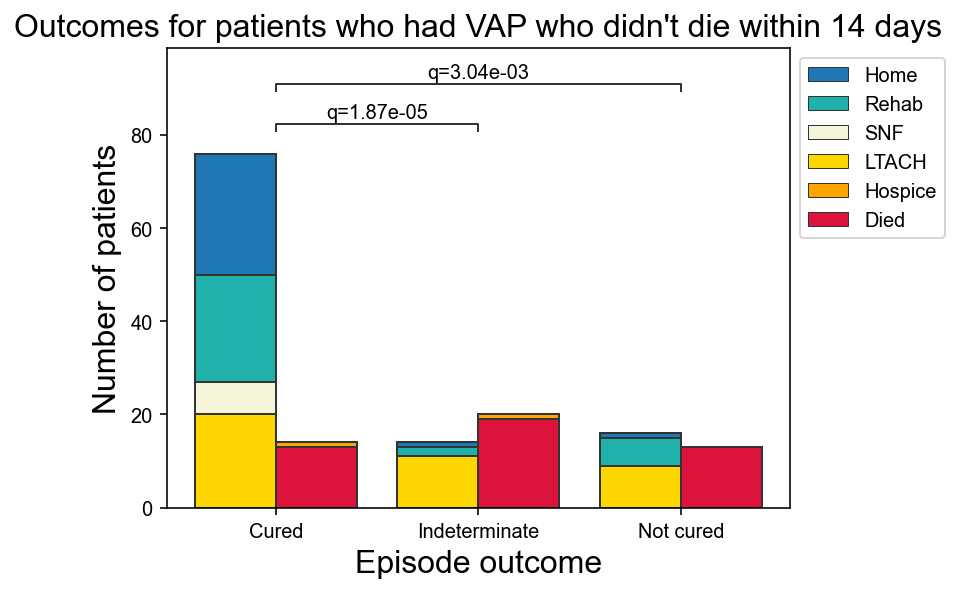

In [77]:

#plot
fig, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)

# Plot Binary outcomes fully transparent
sns.barplot(
    data=simple_df, 
    x="Episode_is_cured", 
    y="cnt",
    hue="Binary_outcome", 
    hue_order=["Positive", "Negative"],
    ax=ax, 
    alpha=0
)

ax.set_ylabel("Number of patients", size=16)
ax.set_xlabel("Episode outcome", size=16)
ax.set_title("Outcomes for patients who had VAP who didn't die within 14 days", size=16)

        
# Annotate with stats the transparent plot
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs, 
    data=simple_df, 
    x="Episode_is_cured",
    y="cnt", 
    verbose=False
)
annotator._verbose = False
annotator.configure(line_width=1)
annotator.set_custom_annotations([f"q={x:.2e}" for x in stat_results_sign.pval_adj])
annotator.annotate();

# Plot all Discharge dispositions
annotator = statannotations.Annotator.Annotator(
    ax, 
    [(("Cured", "Positive"), ("Cured", "Negative"))], 
    data=simple_df, 
    x="Episode_is_cured",
    y="cnt", 
    hue="Binary_outcome",
    hue_order=["Positive", "Negative"],
    verbose=False,
)
max_stack = max([len(group) for group in DISCHARGE_STACKS])
bottom = np.zeros(len(annotator._plotter.group_names))
for i in range(max_stack):
    curr_stack = [group[-i - 1] for j, group in enumerate(DISCHARGE_STACKS) if i < len(group)]
    heights = plot_df.loc[plot_df.Discharge_disposition.isin(curr_stack)].set_index(
        ["Episode_is_cured", "Binary_outcome"]
    ).reindex(annotator._plotter.group_names).cnt.fillna(0)
    ax.bar(
        annotator._plotter.groups_positions._groups_positions_list, 
        heights, 
        color=[DISCH_PALETTE[data.Discharge_disposition.cat.categories.get_loc(x)] for x in curr_stack],
        ec="#333333",
        width=annotator._plotter.plotter.width / len(annotator._plotter.plotter.hue_names),
        align="center",
        bottom=bottom,
    )
    bottom += heights


ax.legend(
    [
        plt.Rectangle(
            [0, 0], 0, 0,
            linewidth=0.5,
            edgecolor="#333",
            facecolor=color,
            label=label
        ) for color, label in zip(DISCH_PALETTE, data.Discharge_disposition.cat.categories)
    ],
    data.Discharge_disposition.cat.categories,loc=2, bbox_to_anchor=(1, 1),
)
    
dump_figure("14days_VAP_outcomes.pdf")

# Are VAP episodes for COVID patient longer?

In [78]:
data.Episode_duration[vap_idx].sum()

2738.0

In [79]:
plot_df = data.loc[vap_idx].copy()
plot_df.Episode_is_cured.replace({
    "Not cured": "Not cured/Indeterminate",
    "Indeterminate": "Not cured/Indeterminate"
}, inplace=True)

In [80]:
stats_results = []

for d1, d2 in itertools.combinations(plot_df.COVID_status.unique(), 2):
        covid_d1_duration = plot_df.Episode_duration[plot_df.COVID_status==d1]
        covid_d2_duration = plot_df.Episode_duration[plot_df.COVID_status==d2]

        stat, pval= scipy.stats.mannwhitneyu(covid_d1_duration,covid_d2_duration)
            
        stats_results.append([d1, d2, pval])  

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2","pval"])
stats_results

,group1,group2,pval
0,False,True,0.00142


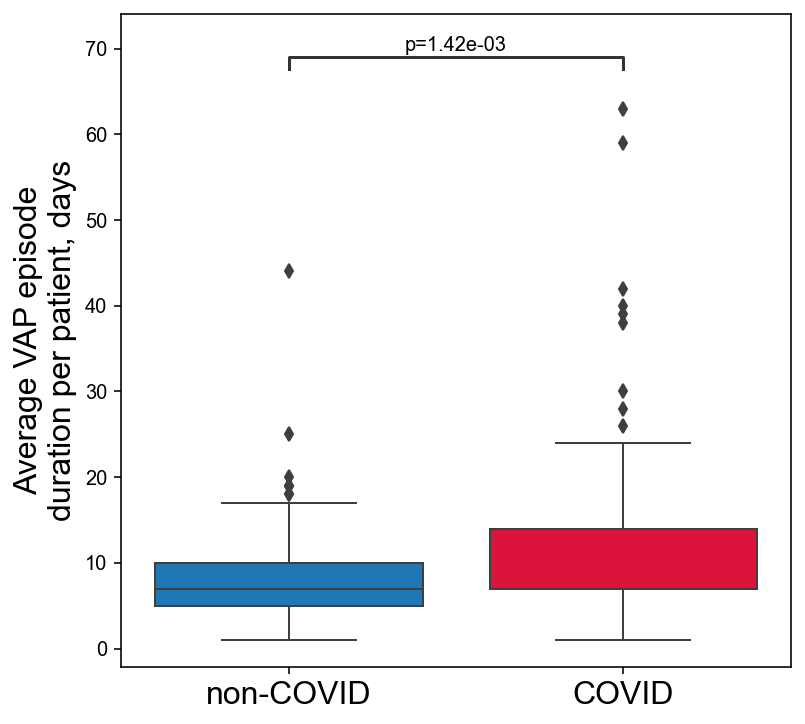

In [81]:
stats_results = []

for d1, d2 in itertools.combinations(plot_df.COVID_status.unique(), 2):
        covid_d1_duration = plot_df.Episode_duration[plot_df.COVID_status==d1]
        covid_d2_duration = plot_df.Episode_duration[plot_df.COVID_status==d2]

        stat, pval= scipy.stats.mannwhitneyu(covid_d1_duration,covid_d2_duration)
            
        stats_results.append([d1, d2, pval])  

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2","pval"])

stat_results_sign = stats_results.loc[stats_results.pval < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))
stats_results

fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(
    data=plot_df,
    x="COVID_status",
    y="Episode_duration",
    palette=['tab:blue','crimson'],
    ax=ax,
    showfliers=True,
    saturation=1,
    linewidth=1
)
ax.set_xlabel("")
ax.set_ylabel("Average VAP episode\nduration per patient, days", size=16)
ax.set_xticklabels(["non-COVID", "COVID"], size=16)

# ax.legend_._loc = 2
# ax.legend_.set_bbox_to_anchor((1, 1))
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs = pairs,
    data=plot_df, 
    x="COVID_status", 
    y="Episode_duration", 
    verbose=False
)
annotator._verbose = False
annotator.set_custom_annotations([f"p={x:.2e}" for x in stat_results_sign.pval])
annotator.annotate();
dump_figure('covid_vs_not_duration.pdf')

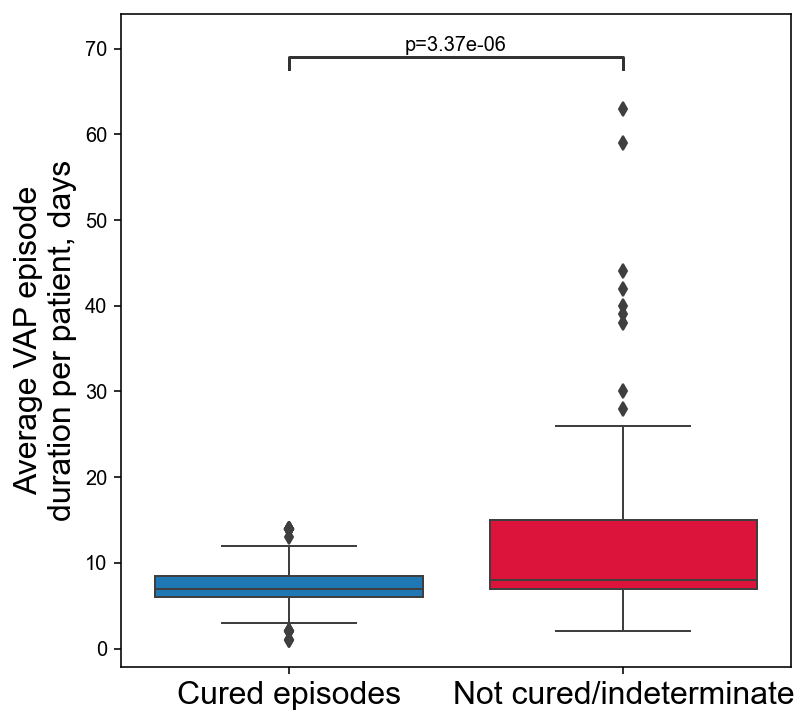

In [82]:
stats_results = []

for d1, d2 in itertools.combinations(plot_df.Episode_is_cured.unique(), 2):
        cured_yes_duration = plot_df.Episode_duration[plot_df.Episode_is_cured=="Cured"]
        cured_no_duration = plot_df.Episode_duration[plot_df.Episode_is_cured=="Not cured/Indeterminate"]

        stat, pval= scipy.stats.mannwhitneyu(cured_yes_duration,cured_no_duration)
            
        stats_results.append([d1, d2, pval])  

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2","pval"])

stat_results_sign = stats_results.loc[stats_results.pval < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))
stats_results

fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(
    data=plot_df,
    x="Episode_is_cured",
    y="Episode_duration",
    palette=['tab:blue','crimson'],
    ax=ax,
    showfliers=True,
    saturation=1,
    linewidth=1
)
ax.set_xlabel("")
ax.set_ylabel("Average VAP episode\nduration per patient, days", size=16)
ax.set_xticklabels(["Cured episodes", "Not cured/indeterminate"], size=16)

# ax.legend_._loc = 2
# ax.legend_.set_bbox_to_anchor((1, 1))
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs = pairs,
    data=plot_df, 
    x="Episode_is_cured", 
    y="Episode_duration", 
    verbose=False
)
annotator._verbose = False
annotator.set_custom_annotations([f"p={x:.2e}" for x in stat_results_sign.pval])
annotator.annotate();
dump_figure('cured_vs_not_duration.pdf')

In [83]:
plot_df = data.loc[vap_idx].copy()


stats_results = []

for d1, d2 in itertools.combinations(plot_df.Episode_is_cured.unique(), 2):
        days1 = plot_df.Episode_duration[plot_df.Episode_is_cured==d1].dropna()
        days2 = plot_df.Episode_duration[plot_df.Episode_is_cured==d2].dropna()
        if days1.size == 0 or days2.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
        stats_results.append([d1, d2, days1.size, days2.size, pval])

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stats_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval, alpha=0.05)[1]
stat_results_sign = stats_results.loc[stats_results.pval_adj < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))
stats_results


,group1,group2,group1_size,group2_size,pval,pval_adj
0,Cured,Indeterminate,128,73,6.137086e-09,1.841126e-08
1,Cured,Not cured,128,78,3.748510e-02,5.325728e-02
2,Indeterminate,Not cured,73,78,5.325728e-02,5.325728e-02


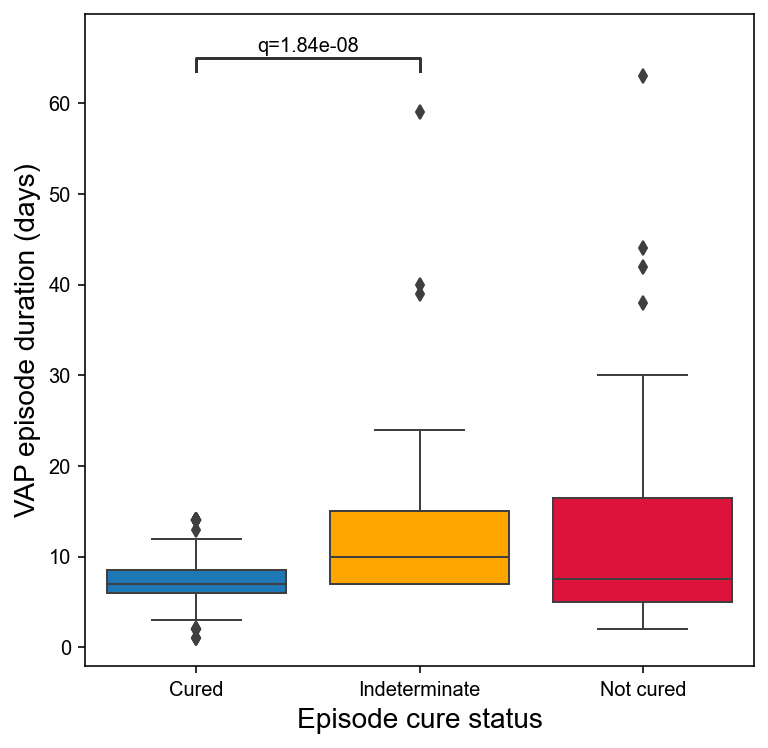

In [84]:


stats_results = []

for d1, d2 in itertools.combinations(plot_df.Episode_is_cured.unique(), 2):
        days1 = plot_df.Episode_duration[plot_df.Episode_is_cured==d1].dropna()
        days2 = plot_df.Episode_duration[plot_df.Episode_is_cured==d2].dropna()
        if days1.size == 0 or days2.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
        stats_results.append([d1, d2, days1.size, days2.size, pval])

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stats_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval, alpha=0.05)[1]
stat_results_sign = stats_results.loc[stats_results.pval_adj < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))
stats_results


fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(
    data=plot_df,
    x="Episode_is_cured",
    y="Episode_duration",
    palette=['tab:blue','orange','crimson'],
    ax=ax,
    showfliers=True,
    saturation=1,
    linewidth=1
)

ax.set_xlabel("Episode cure status", size=14)
ax.set_ylabel("VAP episode duration (days)", size=14)

# ax.legend_._loc = 2
# ax.legend_.set_bbox_to_anchor((1, 1))
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs = pairs,
    data=plot_df, 
    x="Episode_is_cured", 
    y="Episode_duration", 
    verbose=False
)
annotator._verbose = False
annotator.set_custom_annotations([f"q={x:.2e}" for x in stat_results_sign.pval_adj])
annotator.annotate();
dump_figure('cured_vs_indeterm_vs_not_duration.pdf')

In [85]:
# check in group who doesn't die
 

In [87]:
vap_df = data[data.Episode_category.eq("VAP") & data.Episode_etiology.ne("Viral")].groupby("patient").tail(1)
vap_df.Death_date = pd.to_datetime(vap_df.Death_date)
vap_df.day_bucket_starts = pd.to_datetime(vap_df.day_bucket_starts)
vap_df = vap_df.loc[~((vap_df.Death_date - vap_df.day_bucket_starts).dt.days < 14), :]
long_vap_df = vap_df.copy()
long_vap_df.shape

(153, 89)

In [88]:
long_vap_df.Episode_is_cured = long_vap_df.Episode_is_cured.astype("category")
long_vap_df.Episode_is_cured = long_vap_df.Episode_is_cured.cat.reorder_categories([
        'Cured', 
        'Indeterminate', 
        'Not cured'
    ])

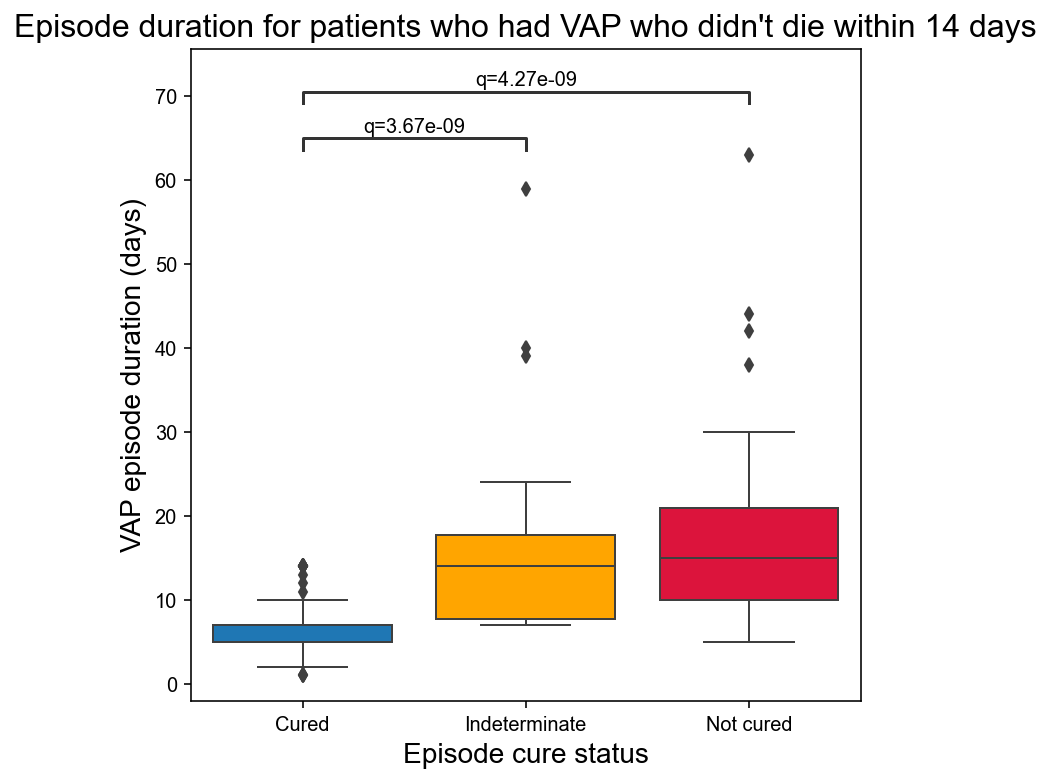

In [89]:
plot_df = long_vap_df.copy()

stats_results = []

for d1, d2 in itertools.combinations(plot_df.Episode_is_cured.unique(), 2):
        days1 = plot_df.Episode_duration[plot_df.Episode_is_cured==d1].dropna()
        days2 = plot_df.Episode_duration[plot_df.Episode_is_cured==d2].dropna()
        if days1.size == 0 or days2.size == 0:
            continue
        pval = scipy.stats.mannwhitneyu(days1, days2).pvalue
        stats_results.append([d1, d2, days1.size, days2.size, pval])

stats_results = pd.DataFrame(stats_results, columns=["group1", "group2",
                                                   "group1_size", "group2_size", "pval"])
stats_results["pval_adj"] = statsmodels.stats.multitest.fdrcorrection(stats_results.pval, alpha=0.05)[1]
stat_results_sign = stats_results.loc[stats_results.pval_adj < 0.05, :]
pairs = []
for _, r in stat_results_sign.iterrows():
        pairs.append((r.group1, r.group2))
stats_results


fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(
    data=plot_df,
    x="Episode_is_cured",
    y="Episode_duration",
    palette=['tab:blue','orange','crimson'],
    ax=ax,
    showfliers=True,
    saturation=1,
    linewidth=1
)

ax.set_title("Episode duration for patients who had VAP who didn't die within 14 days", size=16)
ax.set_xlabel("Episode cure status", size=14)
ax.set_ylabel("VAP episode duration (days)", size=14)

# ax.legend_._loc = 2
# ax.legend_.set_bbox_to_anchor((1, 1))
annotator = statannotations.Annotator.Annotator(
    ax, 
    pairs = pairs,
    data=plot_df, 
    x="Episode_is_cured", 
    y="Episode_duration", 
    verbose=False
)
annotator._verbose = False
annotator.set_custom_annotations([f"q={x:.2e}" for x in stat_results_sign.pval_adj])
annotator.annotate();
dump_figure('cured_vs_indeterm_vs_not_duration_aliveat14.pdf')

# VAP episodes flow

In [90]:
data = data.rename(columns={
    #'Patient_id': 'patient',
    'ICU_stay': 'stay',
    'ICU_day': 'day',
    'clusters': 'cluster'
})
data.Binary_outcome.replace({1: "Died", 0: 'Alive'}, inplace=True)

In [91]:
dfs = []
df_slice = data.loc[data.Episode_category.isin(["CAP", "HAP", "VAP", "Non-PNA-ctrl"]), :]
max_episode = df_slice.groupby("patient").day.count().max()
for episode_num in range(max_episode):
    episode_slice = df_slice.groupby("patient").nth(episode_num).reset_index()
    df = episode_slice.loc[:, ["Episode_category", "Episode_is_cured", "patient"]].copy()
    df["episode_num"] = episode_num + 1
    dfs.append(df)
df = pd.concat(dfs).reset_index(drop=True)

In [92]:
sankey_df = df.reset_index().loc[
    :, 
    ["patient", "episode_num", "Episode_category"]
].pivot(
    index=["patient"],
    columns="episode_num",
    values="Episode_category"
).reset_index().fillna(-1)

In [93]:
df_ = data.copy()
df_["outcome"] = "Alive"
df_.loc[df_.Binary_outcome.eq("Died"), "outcome"] = "Dead"
patient_outcome = df_.set_index("patient").groupby("patient").head(1).outcome

In [94]:
for c in sankey_df.columns[1:]:
    idx = sankey_df[c].eq(-1)
    sankey_df.loc[idx, c] = patient_outcome[sankey_df.patient[idx]].values

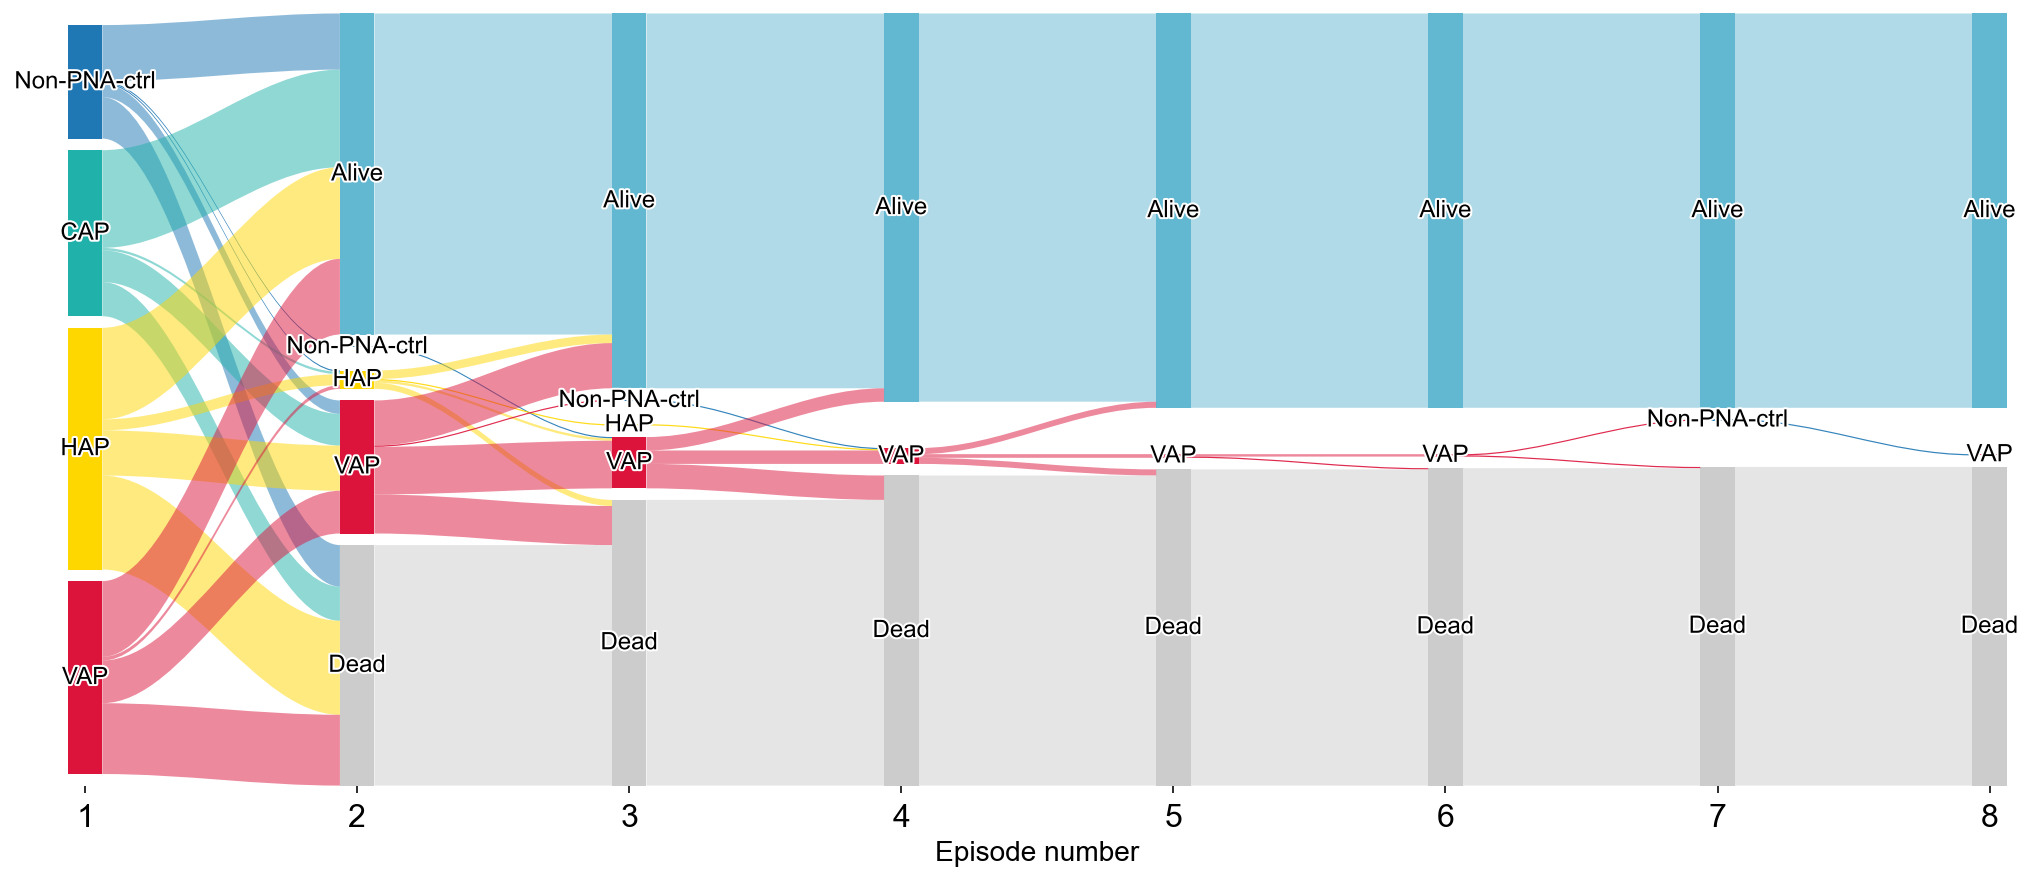

In [95]:
colors = {
    "Non-PNA-ctrl": DISCH_PALETTE[0],
    "CAP": DISCH_PALETTE[1],
    "HAP": DISCH_PALETTE[3],
    "VAP": DISCH_PALETTE[5],
    "Alive": "#62b7d1",
    "Dead": "#ccc"
}
fig, ax = plt.subplots(figsize=(14, 6), constrained_layout=True)
diag = sankey.Sankey(
    sankey_df.iloc[:, 1:], 
    ax=ax, 
    order=["Alive", "Non-PNA-ctrl", "CAP", "HAP", "VAP", "Dead"],
    block_width=0.2,
    colors=colors,
    alpha=0.5
)
diag.draw()
ax.set_title("", size=16)
ax.set_xticks(
    [diag.block_width / 2 + diag.flow_width * x + diag.block_width * x for x in range(sankey_df.shape[1] - 1)]
)
ax.set_xticklabels(sankey_df.columns[1:].astype(int))
ax.set_xlabel("Episode number", size=14)
ax.get_xaxis().set_visible(True)
ax.tick_params(axis="x", pad=5, labelsize=16)
dump_figure('pneumonia_episodes_flow.pdf')

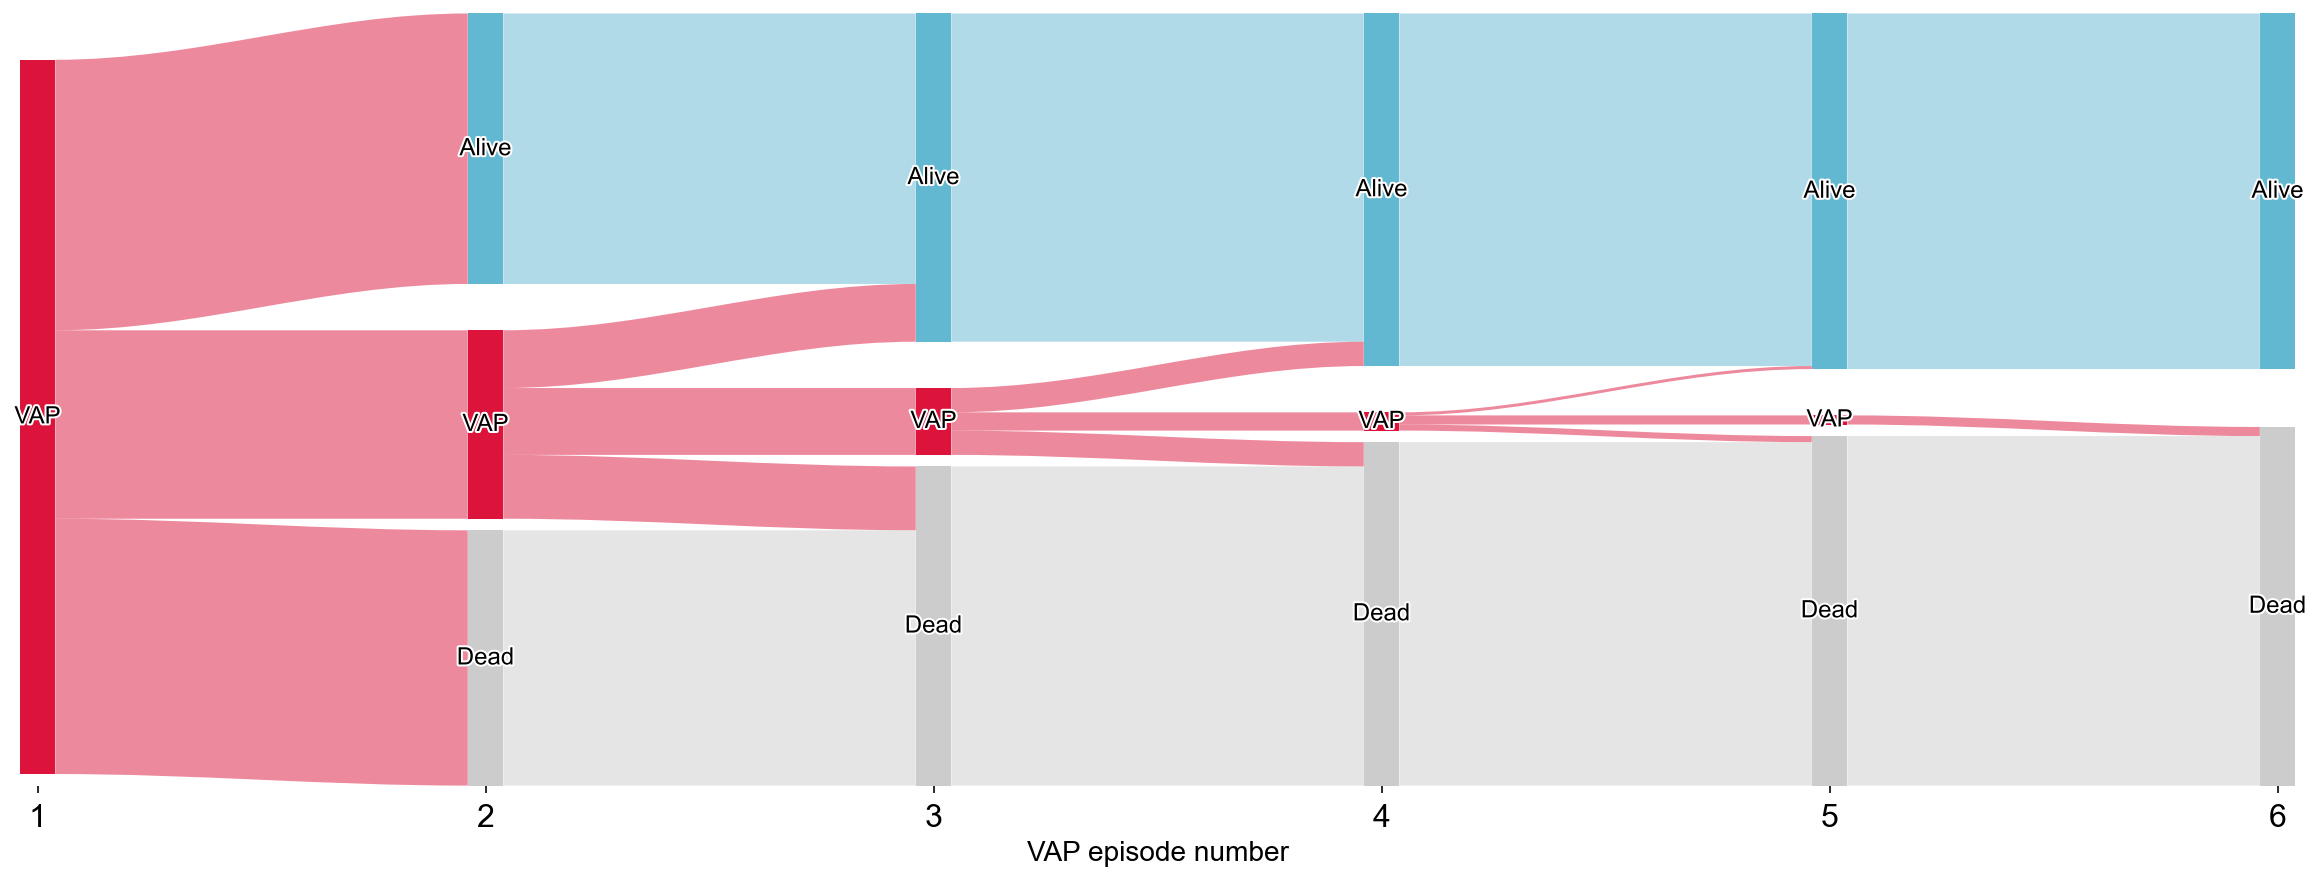

In [96]:
df_slice = data.loc[data.Episode_category.isin(["VAP"]), :]
dfs = []
max_episode = df_slice.groupby("patient").day.count().max()
for episode_num in range(max_episode):
    episode_slice = df_slice.groupby("patient").nth(episode_num).reset_index()
    df = episode_slice.loc[:, ["Episode_category", "Episode_is_cured", "patient"]].copy()
    df["episode_num"] = episode_num + 1
    dfs.append(df)
df = pd.concat(dfs).reset_index(drop=True)

sankey_df = df.reset_index().loc[
    :, 
    ["patient", "episode_num", "Episode_category"]
].pivot(
    index=["patient"],
    columns="episode_num",
    values="Episode_category"
).reset_index().fillna(-1)

df_ = data.copy()
df_["outcome"] = "Alive"
df_.loc[df_.Binary_outcome.eq("Died"), "outcome"] = "Dead"
patient_outcome = df_.set_index("patient").groupby("patient").head(1).outcome

for c in sankey_df.columns[1:]:
    idx = sankey_df[c].eq(-1)
    sankey_df.loc[idx, c] = patient_outcome[sankey_df.patient[idx]].values
    
sankey_df['6']=patient_outcome[sankey_df.patient].values

colors = {
    "Non-PNA-ctrl": DISCH_PALETTE[0],
    "CAP": DISCH_PALETTE[1],
    "HAP": DISCH_PALETTE[3],
    "VAP": DISCH_PALETTE[5],
    "Alive": "#62b7d1",
    "Dead": "#ccc"
}
fig, ax = plt.subplots(figsize=(16, 6), constrained_layout=True)
diag = sankey.Sankey(
    sankey_df.iloc[:, 1:], 
    ax=ax, 
    order=["Alive", "Non-PNA-ctrl", "CAP", "HAP", "VAP", "Dead"],
    block_width=0.2,
    colors=colors,
    alpha=0.5
)
diag.draw()
ax.set_title("", size=16)
ax.set_xticks(
    [diag.block_width / 2 + diag.flow_width * x + diag.block_width * x for x in range(sankey_df.shape[1] - 1)]
)
ax.set_xticklabels(sankey_df.columns[1:].astype(int))
ax.set_xlabel("VAP episode number", size=14)
ax.get_xaxis().set_visible(True)
ax.tick_params(axis="x", pad=5, labelsize=16)
dump_figure('vap_episodes_flow.pdf')